In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 40)


In [16]:
# import dataset
dataset = pd.read_csv('pd_speech_features.csv', header=1)

# prepare and preprocess data
#756/3 = 252

new_data_frame = []  # Initialize an empty list to store mean rows

# Iterate through the dataset in steps of 3 rows
for i in range(0, len(dataset), 3):
    # Compute the mean of every 3 rows and append it to the list
    new_data_frame.append(dataset.iloc[i:i + 3].mean())

# Convert the list of means into a new DataFrame
new_data_frame = pd.DataFrame(new_data_frame)

# convet float to int int gender column

new_data_frame['gender'] = new_data_frame['gender'].astype(int)
new_data_frame['class'] = new_data_frame['class'].astype(int)



# drop the id column
data = new_data_frame.drop(columns=['id'])

print(data['class'].value_counts(normalize=True))




class
1    0.746032
0    0.253968
Name: proportion, dtype: float64


In [17]:
from sklearn.tree import DecisionTreeClassifier

# Feature matrix (X) and target vector (y)
X = data.drop('class', axis=1)
y = data['class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Optimized DecisionTreeClassifier
classifier = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    max_depth=7,
    min_samples_leaf=2,
    min_samples_split=10,
    random_state=42
)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
classifier.fit(X_resampled, y_resampled)
y_pred = classifier.predict(X_test)


# Confusion Matrix and Accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nAccuracy:", accuracy)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[ 8  7]
 [ 5 31]]

Accuracy: 0.7647058823529411

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.82      0.86      0.84        36

    accuracy                           0.76        51
   macro avg       0.72      0.70      0.70        51
weighted avg       0.76      0.76      0.76        51



In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuries = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    classifier.fit(X_resampled, y_resampled)
    y_pred = classifier.predict(X_test)

    accuries.append(accuracy_score(y_test, y_pred))
    
print("Cross-Validation Score:", np.mean(accuries))

print("Cross-Validation Score:", cross_val_score(classifier, X, y, cv=kf).mean())

#report
y_pred = classifier.predict(X_test)
print("Report:", classification_report(y_test, y_pred))


Cross-Validation Score: 0.7261960784313727
Cross-Validation Score: 0.7501176470588234
Report:               precision    recall  f1-score   support

           0       0.58      0.50      0.54        14
           1       0.82      0.86      0.84        36

    accuracy                           0.76        50
   macro avg       0.70      0.68      0.69        50
weighted avg       0.75      0.76      0.75        50



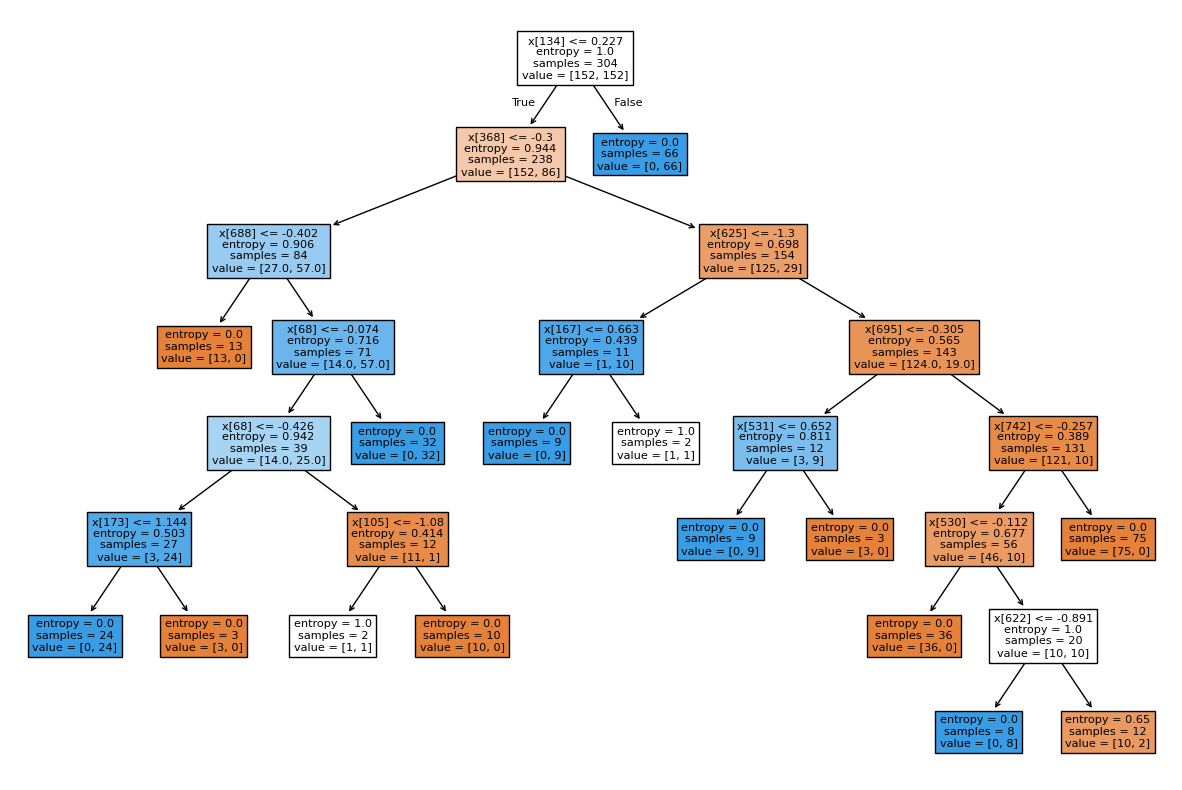

In [19]:
# plot the tree
from sklearn import tree
plt.figure(figsize=(15, 10))
tree.plot_tree(classifier, filled=True)
plt.show()

In [20]:
from EFSA import FeatureSelector

fs = FeatureSelector(X=X ,y=y)



selected_features ,f_score = fs.anova_test(k_features=5)

print(selected_features)

# get index for std_9th_delta_delta

for feature in selected_features:
    print(X.columns.get_loc(feature), feature)


['mean_MFCC_2nd_coef', 'tqwt_stdValue_dec_12', 'tqwt_maxValue_dec_11', 'tqwt_maxValue_dec_12', 'tqwt_minValue_dec_12']
58 mean_MFCC_2nd_coef
584 tqwt_stdValue_dec_12
655 tqwt_maxValue_dec_11
656 tqwt_maxValue_dec_12
620 tqwt_minValue_dec_12


In [21]:
from DecisionTree import CARTClassifier



cart = CARTClassifier(
    max_depth=7,
    min_samples_split=2
)


cart.fit(X_resampled, y_resampled)



# print accuracy
y_pred = cart.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.74


<Figure size 4000x2400 with 0 Axes>

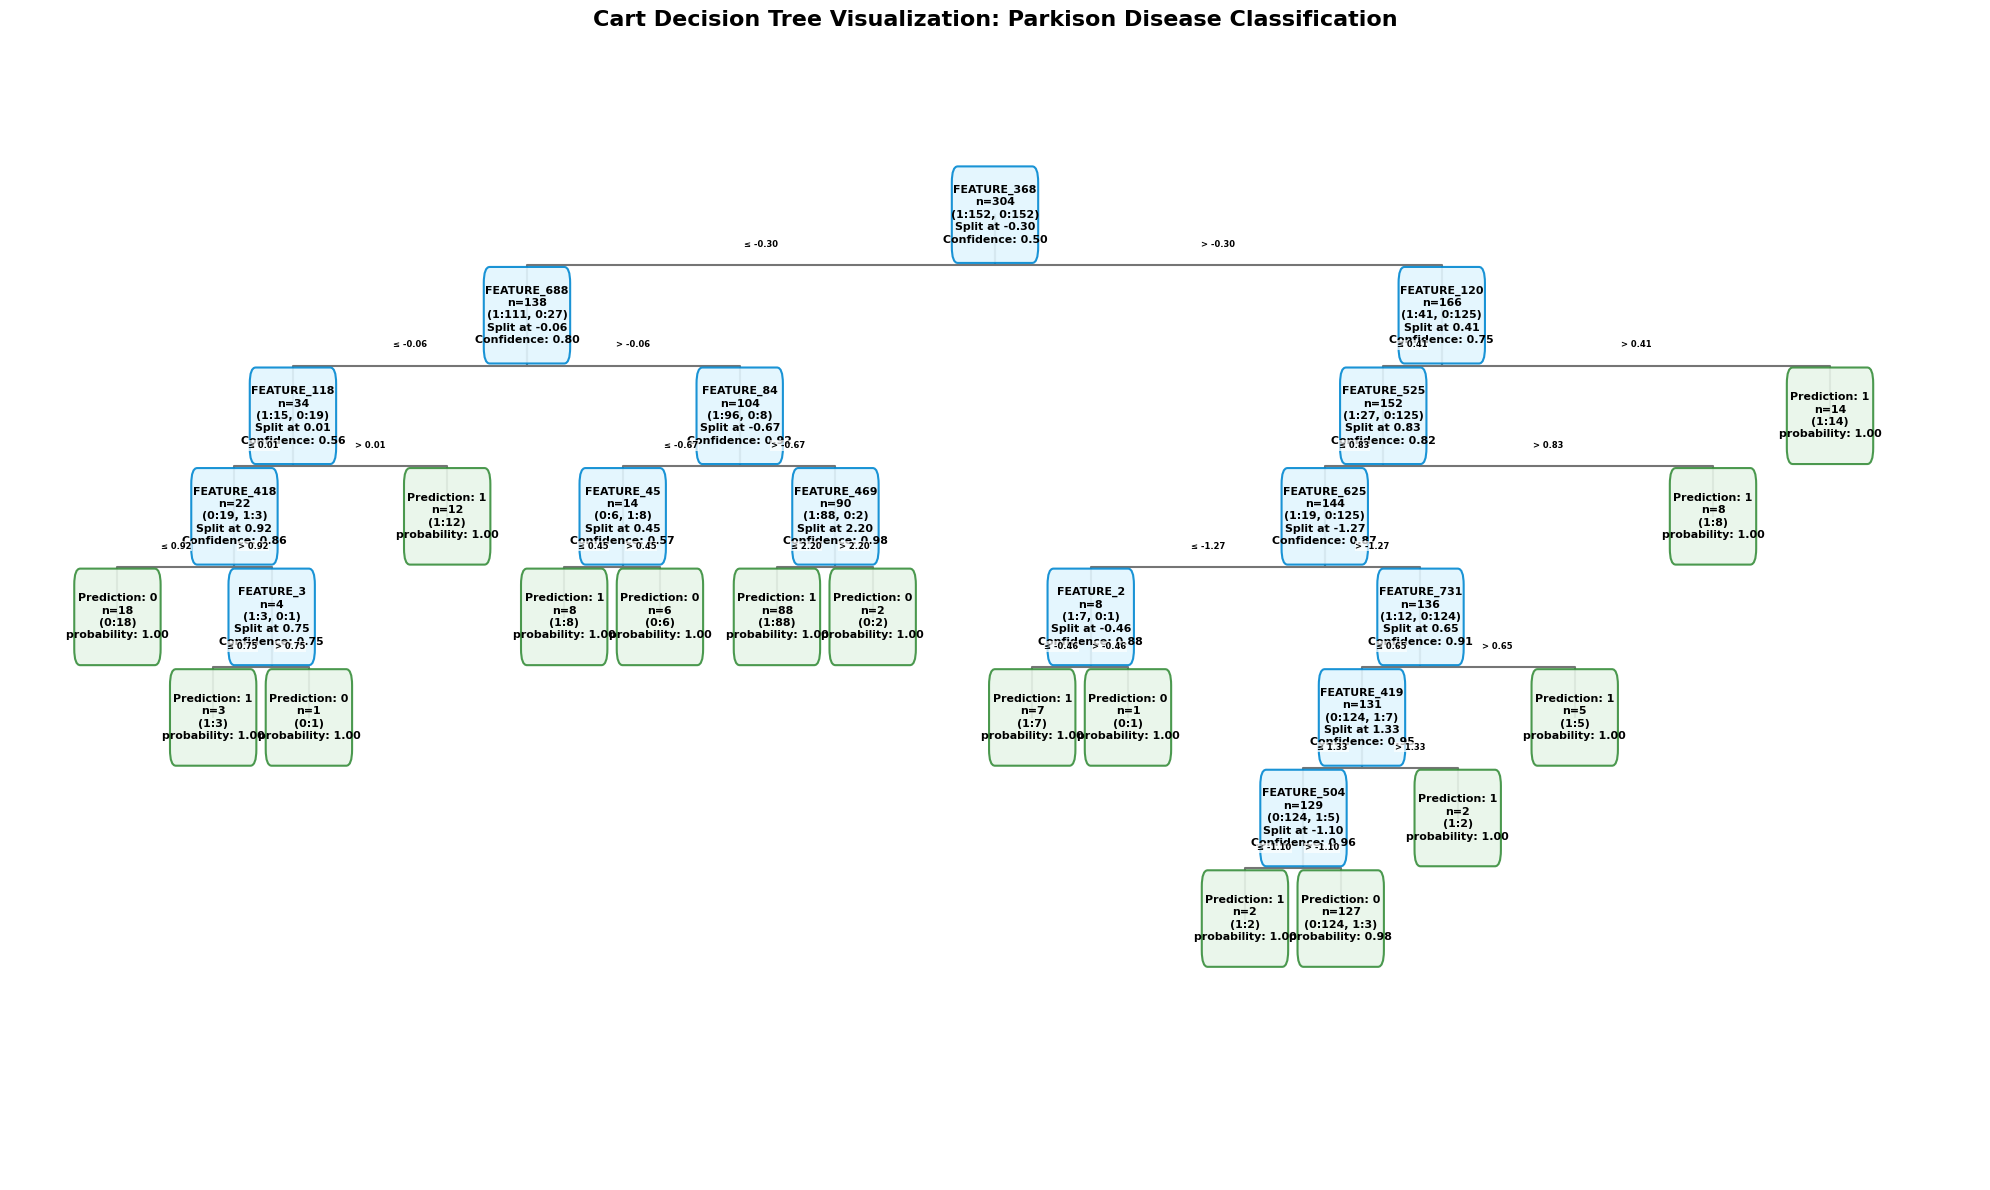

In [22]:

# Visualize the tree
plt.figure(figsize=(40, 24))
cart.visualize()
plt.show()

In [23]:
# compare the two models
y_pred_sklearn = classifier.predict(X_test)
y_pred_cart = cart.predict(X_test)

print('Classification report of sklearn DecisionTreeClassifier: \n', classification_report(y_test, y_pred_sklearn))
print('Classification report of CARTClassifier: \n', classification_report(y_test, y_pred_cart))

Classification report of sklearn DecisionTreeClassifier: 
               precision    recall  f1-score   support

           0       0.58      0.50      0.54        14
           1       0.82      0.86      0.84        36

    accuracy                           0.76        50
   macro avg       0.70      0.68      0.69        50
weighted avg       0.75      0.76      0.75        50

Classification report of CARTClassifier: 
               precision    recall  f1-score   support

           0       0.55      0.43      0.48        14
           1       0.79      0.86      0.83        36

    accuracy                           0.74        50
   macro avg       0.67      0.64      0.65        50
weighted avg       0.73      0.74      0.73        50



In [24]:
#plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted sklearn')
plt.ylabel('Truth')
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_cart)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted cart')
plt.ylabel('Truth')
plt.show()

#plot some random predictions from both models
import random

for i in range(5):
    index = random.randint(0, len(y_test) - 1)
    print('Truth: ', y_test.iloc[index], 'Predicted sklearn: ', y_pred_sklearn[index], 'Predicted cart: ', y_pred_cart[index])
    


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
#plot top 10 important features of the sklearn model
features = X.columns
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

print(indices[:10])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(10), importances[indices[:10]])
plt.xticks(range(10), features[indices[:10]], rotation=90)
plt.show()



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
